In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
box = pd.read_csv('./output.csv')
box.head()

,image,width,height,label,xmin,ymin,xmax,ymax
0,A01_F03_C074_C_200114_3001_20S_000001.061.jpg,1920,1080,1,1189.35,152.11,1570.34,436.59998
1,A01_F03_C074_C_200114_3001_20S_000001.941.jpg,1920,1080,1,1158.02,85.69,1571.60,437.86002
2,A01_F03_C074_C_200114_3001_20S_000002.139.jpg,1920,1080,1,1186.84,81.93,1571.59,436.60000
3,A01_F03_C074_C_200114_3001_20S_000002.204.jpg,1920,1080,1,1179.32,84.44,1572.84,440.37000
4,A01_F03_C074_C_200114_3001_20S_000006.538.jpg,1920,1080,1,937.44,100.73,1295.87,435.35000


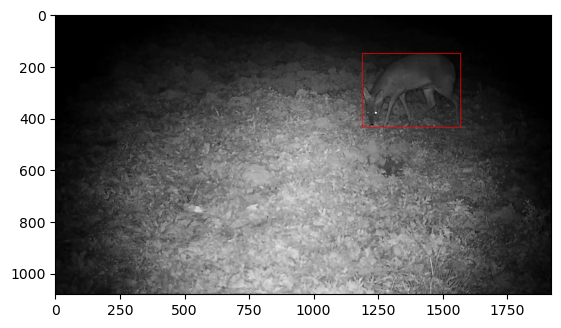

In [3]:
sample = cv2.imread('./data/image/gorani/A01_F03_C074_C_200114_3001_20S_000001.061.jpg')
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
point = box.iloc[0]
pt1 = (int(point['xmin']), int(point['ymax']))
pt2 = (int(point['xmax']), int(point['ymin']))
cv2.rectangle(sample, pt1, pt2, color=(255,0,0), thickness=2)
plt.imshow(sample)
plt.show()

In [4]:
class Gorani(Dataset):
    def __init__(self, df, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = df["image"].unique() # all image filenames
        self.df = df
        self.image_dir = image_dir # dir to image files
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        records = self.df[self.df["image"] == image_id]
        image = cv2.imread(f"{self.image_dir}/{image_id}", cv2.IMREAD_COLOR)
        heights, widths = image.shape[:2]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image = torch.tensor(image)
        image = image.permute(2,0,1)
        
        
        boxes = records[["xmin", "ymin", "xmax", "ymax"]].values
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        masks = []
        for box in boxes:
            mask = np.zeros([int(heights), int(widths)], np.uint8)
            masks.append(cv2.rectangle(mask, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), 1, -1))

        masks = torch.tensor(masks, dtype=torch.uint8)

        # class가 1종류이기 때문에 label은 1로만 지정
        #labels = torch.ones((records.shape[0]), dtype=torch.int64)
        labels = torch.tensor((records["label"].values), dtype=torch.int64)
        
        target = {}
        target["boxes"] = torch.tensor(boxes)
        target["labels"] = labels
        target['masks'] = masks
        target["image_id"] = torch.tensor([idx])
        target["area"] = area


        if self.transforms:
            sample = {"image": image, "boxes": target["boxes"], "labels": labels}
            sample = self.transforms(**sample)
            image = sample["image"]
            target["boxes"] = torch.stack(tuple(map(torch.tensor, zip(*sample["boxes"])))).permute(1, 0)

        return image, target

    def __len__(self):
        return self.image_ids.shape[0]

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [6]:
dir_train = "data\image\conbine"
train_ds = Gorani(box, dir_train)

In [7]:
train_dl = DataLoader(train_ds, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [8]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [9]:
num_classes = 3

model = get_instance_segmentation_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0005, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [11]:
model.train()

num_epochs = 5

for epoch in range(num_epochs):
    
    for i, (images, targets) in enumerate(train_dl):
      optimizer.zero_grad()
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
      loss_dict = model(images, targets)

      losses = sum(loss for loss in loss_dict.values())

      losses.backward()
      optimizer.step()

      print(f'Epoch {epoch+1} - Total: {losses:.4f}, Regression: {loss_dict["loss_box_reg"]:.4f}, Classifier: {loss_dict["loss_classifier"]:.4f}')
  
    scheduler.step()

Epoch 1 - Total: 3.9737, Regression: 0.1967, Classifier: 1.0846
Epoch 1 - Total: 4.8079, Regression: 0.0257, Classifier: 0.0297
Epoch 1 - Total: 1.0259, Regression: 0.0272, Classifier: 0.1220
Epoch 1 - Total: 1.5490, Regression: 0.1989, Classifier: 0.7496
Epoch 1 - Total: 0.9147, Regression: 0.1321, Classifier: 0.2344
Epoch 1 - Total: 0.4479, Regression: 0.0450, Classifier: 0.0849
Epoch 1 - Total: 0.6938, Regression: 0.0927, Classifier: 0.1104
Epoch 1 - Total: 0.7625, Regression: 0.0909, Classifier: 0.0866
Epoch 1 - Total: 0.7451, Regression: 0.0913, Classifier: 0.0991
Epoch 1 - Total: 0.5704, Regression: 0.0718, Classifier: 0.1137
Epoch 1 - Total: 1.0558, Regression: 0.0561, Classifier: 0.0633
Epoch 1 - Total: 0.6833, Regression: 0.0645, Classifier: 0.1005
Epoch 1 - Total: 0.7119, Regression: 0.0391, Classifier: 0.0539
Epoch 1 - Total: 0.4646, Regression: 0.0457, Classifier: 0.1350
Epoch 1 - Total: 0.3615, Regression: 0.0478, Classifier: 0.0662
Epoch 1 - Total: 1.1568, Regression: 0.0

In [35]:
torch.save(model, 'model2.pth')

In [51]:
model = torch.load('model.pth')
#model = torch.load('./rcnn_checkpoint/model_epoch_10.pth')

#images = cv2.imread('../model/Dataset/images/A11_H74_C090_C_181022_5037_21S_000000.669.jpg', cv2.IMREAD_COLOR)
#images = cv2.imread('../model/OriginData/TS_11.노루/A11_H29_C007_C_210224_5268_20S_000011.012.jpg', cv2.IMREAD_COLOR)

images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
images /= 255.0
sample = images
images = torch.tensor(images)
images = images.permute(2,0,1)
images = torch.unsqueeze(images, 0)
images = images.to(device)

print(images)
model.eval()
cpu_device = torch.device("cpu")

preds = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in preds]
#print(outputs)
mask = outputs[0]['scores'] >= 0.7
boxes = outputs[0]["boxes"][mask].detach().numpy().astype(np.int32)
scores = outputs[0]['scores'][mask].detach().numpy()
labels = outputs[0]['labels'][mask].detach().numpy()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


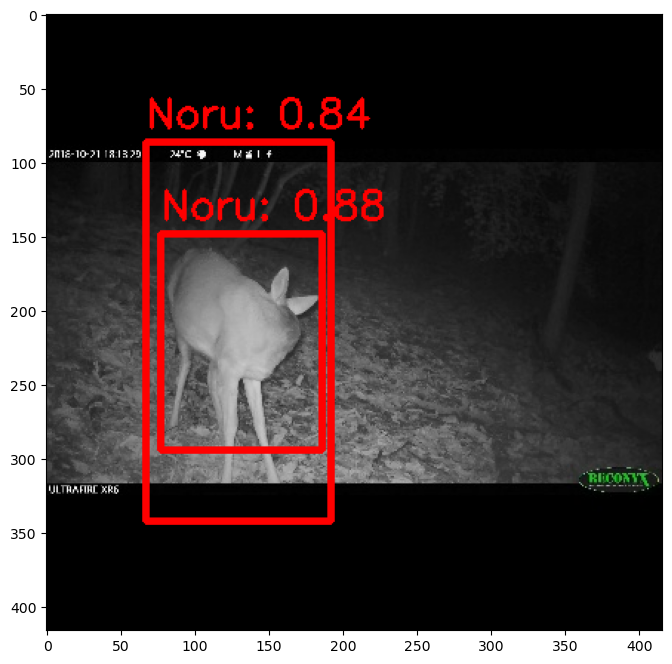

In [48]:
class_labels = {1: 'Gorani', 2: 'Noru'}
plt.figure(figsize=(12, 8), dpi=100)

for box, score, label in zip(boxes, scores, labels):
    cv2.rectangle(sample, 
                  (box[0], box[1]), 
                  (box[2], box[3]), 
                  (220, 0, 0), 3)
    text = f'{class_labels[label]}: {score:.2f}'
    cv2.putText(sample, 
                text, 
                (box[0], box[1] - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.9, 
                (255, 0, 0), 
                2)


plt.imshow(sample)
plt.show()